# [Projet 6: Catégorisez automatiquement des questions](https://openclassrooms.com/fr/projects/categorisez-automatiquement-des-questions)
(parcours data: [here](https://openclassrooms.com/paths/63-data-scientist))

## Data cleaning

Data exporter (StackExchange): [here](https://data.stackexchange.com/stackoverflow/query/new).  
My minimal SQL query:
```
SELECT
   Id,Body,Title,Tags
FROM
   Posts
WHERE
   Id < 5000 and Body<>'' and Title<>'' and Tags <>''
```

Resources:
- [tutorial on kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words) (I did this basically on my own, but look at the features with scikit-learn section)

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(HOME+'Documents/GitHub/OCDataSciencePath/Project6/Work/')    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import pandas as pd
from scipy.sparse import hstack
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

Some info and uses for [BeautifulSoup](https://pypi.org/project/beautifulsoup4/): [here](https://www.pythonforbeginners.com/beautifulsoup/beautifulsoup-4-python),

In [2]:
from bs4 import BeautifulSoup # conda install beautifulsoup4

Some info and uses for [NLTK](https://pypi.org/project/nltk/): [here](http://www.nltk.org/book/),

In [3]:
import nltk
#nltk.download('punkt')

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [5]:
from Pkg.helper import basicHTMLTextCleaner, basicTagTextCleaner, isValidData # needs correct working directory

### Data

In [13]:
if HOST == 'Arthurs-MacBook-Pro.local':
    pathToDataDir = HOME+'Documents/Dropbox/Transit/OCDataScienceData/Project6/Data/'    # @home
    pathToIntellDir = HOME+'Documents/Dropbox/Transit/OCDataScienceData/Project6/Intelligence/'    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))

In [14]:
filename = 'QueryResults_10k.csv'
df = pd.read_csv(pathToDataDir+filename,index_col='Id')

In [15]:
n,p = df.shape
k = .8
df_train,df_test = df.iloc[:int(k*n),:].copy(),df.iloc[int(k*n):,:].copy()

In [39]:
print(df_train.shape,df_test.shape)
df_train.sample(5)

(9028, 6) (2258, 6)


,Body,Title,Tags,Body_clean,Title_clean,Tags_clean
Id,,,,,,
66810,<p>Has anybody experience in building a custom...,Custom style with Qt,<qt><widget>,anybodi experi build custom style qt mind comp...,custom style qt,<qt><widget>
56944,"<p>Encouraged by SO, I'm trying to write an AS...",secure way to authenticate administrator in AS...,<asp.net><openid><dotnetopenauth>,encourag tri write asp net site use openid use...,secur way authent administr asp net site use o...,<asp.net><openid><dotnetopenauth>
50315,"<p>I have a couple of solutions, but none of t...",How do you allow multiple file uploads on an i...,<javascript><flash><authentication><activex><f...,coupl solut none work perfectli platform asp n...,allow multipl file upload intern window authen...,<javascript><flash><authentication><activex><f...
68578,<p>Is there a way to fall through multiple cas...,Multiple cases in switch statement,<c#><switch-statement>,way fall multipl case statement without state ...,multipl case switch statement,<c#><switch-statement>
24579,<p>Is there a good ruby gem for a WYSIWYG edit...,WYSIWYG editor gem for Rails?,<ruby-on-rails><ruby><gem>,good rubi gem wysiwyg editor easili work rail app,wysiwyg editor gem rail,<ruby-on-rails><ruby><gem>


### Basic text cleaning

In [11]:
def applyCleaner(df,tokenizer,stopwords,stemer):
    '''
    applies the cleaner to a pd.DataFrame. See called functions for help.
    '''
    for c in ('Body','Title'):
        df[c+'_clean'] = df[c].apply(lambda x: basicHTMLTextCleaner(x,tokenizer,stopwords,stemer))
    for c in ('Tags',):
        df[c+'_clean'] = df[c].apply(lambda x: basicTagTextCleaner(x))
        
    return df

In [20]:
stopwords = set(nltk.corpus.stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemer = nltk.PorterStemmer()

df_train = applyCleaner(df_train,tokenizer,stopwords,stemer)
df_test = applyCleaner(df_test,tokenizer,stopwords,stemer)

In [21]:
# save transformers for later
pickle.dump(stopwords, open(pathToIntellDir+'stopwords.pkl','wb'))
pickle.dump(tokenizer, open(pathToIntellDir+'tokenizer.pkl','wb'))
pickle.dump(stemer, open(pathToIntellDir+'stemer.pkl','wb'))

In [22]:
df_train.sample(5)

,Body,Title,Tags,Body_clean,Title_clean,Tags_clean
Id,,,,,,
49334,"<p>In my database, I have an entity table (let...",Querying collections of value type in the Crit...,<hibernate><enums><hql>,databas entiti tabl let call entiti entiti num...,queri collect valu type criteria api hibern,<hibernate><enums><hql>
55828,<p>Is there a simple method of parsing XML fil...,How does one parse XML files?,<c#><xml>,simpl method pars xml file c,one pars xml file,<c#><xml>
51139,<p>I'm trying to create an SSIS package that t...,How to insert a row into a dataset using SSIS?,<sql-server><ssis>,tri creat ssi packag take data xml data sourc ...,insert row dataset use ssi,<sql-server><ssis>
55296,<p>I'm looking to implement httpOnly in my leg...,How exactly do you configure httpOnly Cookies ...,<security><asp-classic><httponly>,look implement httponli legaci asp classic sit...,exactli configur httponli cooki asp classic,<security><asp-classic><httponly>
59390,"<p>In a ColdFusion Component (CFC), is it nece...",ColdFusion: Is it safe to leave out the variab...,<coldfusion><cfc>,coldfus compon cfc necessari use fulli qualifi...,coldfus safe leav variabl keyword cfc,<coldfusion><cfc>


### Vectorization

Resources
- [scikit tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) (also used in this [kaggle example](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words))

*Input texts:*

In [23]:
# count occurences (beware to fit the dictionary only on train data!)
# NB: deal with tags separately, as they basically need one-hot encoding
V_body = 100 # 20 # 500
count_body = CountVectorizer(analyzer = "word",   # entities to be counted
                             preprocessor = None, # because we did it ourselves
                             lowercase = False,   # because we did it ourselves
                             stop_words = None,   # because we did it ourselves
                             tokenizer = None,    # because we did it ourselves
                             max_features = V_body) 

count_body.fit(df_train['Body_clean'])
vocab_body = count_body.vocabulary_

V_title = 20 # 5 # 100
count_title = CountVectorizer(analyzer = "word",   # entities to be counted
                              preprocessor = None, # because we did it ourselves
                              lowercase = False,   # because we did it ourselves
                              stop_words = None,   # because we did it ourselves
                              tokenizer = None,    # because we did it ourselves
                              max_features = V_title) 

count_title.fit(df_train['Title_clean'])
vocab_title = count_title.vocabulary_

# transform to vectors using the fitted dictionaries
body_train = count_body.transform(df_train['Body_clean'])
title_train = count_title.transform(df_train['Title_clean'])

body_test = count_body.transform(df_test['Body_clean'])
title_test = count_title.transform(df_test['Title_clean'])

In [24]:
# use TF-IDF (beware to fit the IDF with train data!)
tfidf_body = TfidfTransformer(use_idf=True).fit(body_train)
tfidf_title = TfidfTransformer(use_idf=True).fit(title_train)

# transform using the fitted IDF
body2_train = tfidf_body.transform(body_train)
title2_train = tfidf_title.transform(title_train)

body2_test = tfidf_body.transform(body_test)
title2_test = tfidf_title.transform(title_test)

In [27]:
# save transformers for later use
pickle.dump(count_body, open(pathToIntellDir+'count_body.pkl','wb'))
pickle.dump(count_title, open(pathToIntellDir+'count_title.pkl','wb'))

pickle.dump(tfidf_body, open(pathToIntellDir+'tfidf_body.pkl','wb'))
pickle.dump(tfidf_title, open(pathToIntellDir+'tfidf_title.pkl','wb'))

In [28]:
body2_train[0,:].toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.1963628 ,  0.        ,  0.        ,  0.27043017,
         0.        ,  0.23514089,  0.        ,  0.35791596,  0.23923973,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.24967691,
         0.        ,  0.        ,  0.        ,  0.23707879,  0.27108839,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.2038933 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.23691526,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [29]:
title2_train[0,:].toarray()

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]])

*Target tags:*

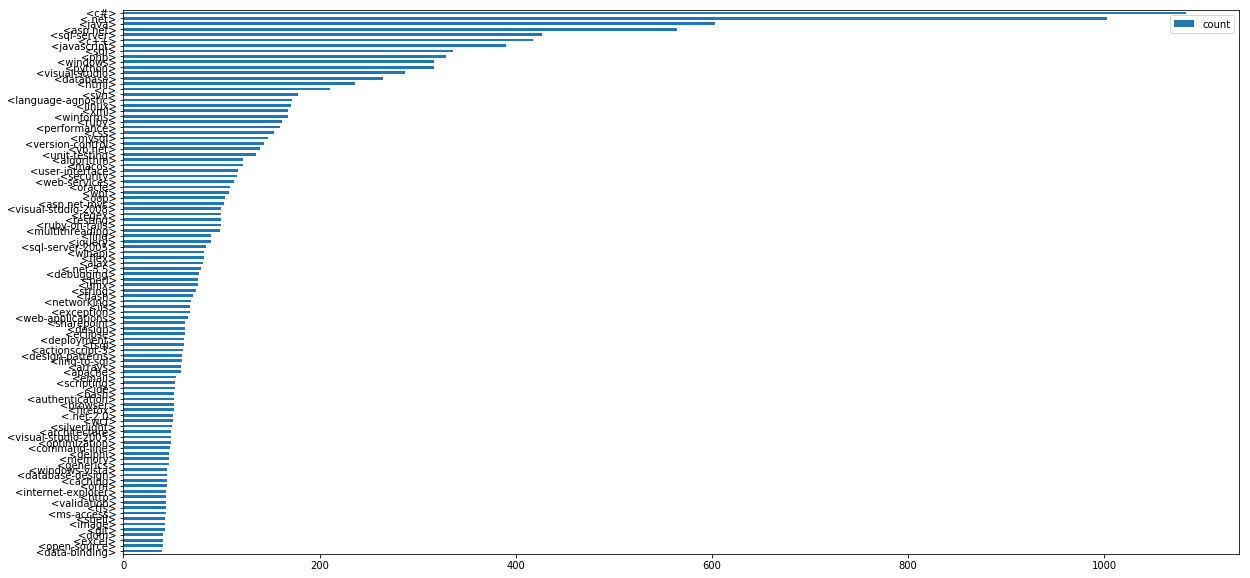

In [30]:
# analysis of the tags (NB: here we only 'multiplly'-one-hot encode: there is no need to compute TF-IDF!)

# count occurences
V_tag = 100 # 20 # NB (after viewing the plots): a looot of tags appear only once
count_tag = CountVectorizer(analyzer = "word",   # entities to be counted
                            preprocessor = None, # because we did it ourselves
                            lowercase = False,   # because we did it ourselves
                            stop_words = None,   # because we did it ourselves
                            tokenizer = None,    # because we did it ourselves
                            token_pattern = '<[^[<>]*>', # otherwise, treats tags as words
                            max_features = V_tag) 

count_tag.fit(df_train['Tags_clean'])
vocab_tag = count_tag.vocabulary_

# transform
tag_train = count_tag.transform(df_train['Tags_clean'])
tag_test = count_tag.transform(df_test['Tags_clean'])

# plot number of questions per tag
tagCount = pd.DataFrame(index=['count'])
for t,i in vocab_tag.items():
    tagCount[t] = tag_train[:,i].sum()
tagCount = tagCount.transpose()
tagCount = tagCount.sort_values(by='count',ascending=True)
tagCount.plot(kind='barh',figsize=(20,10))

In [38]:
# save transofrmer for later use
pickle.dump(count_tag, open(pathToIntellDir+'count_tag.pkl','wb'))

In [32]:
tag_train[0,:].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

*Merge together:*

In [33]:
x_train = hstack((body2_train,title2_train)) # need hstack because we work on sparse matrices...
x_test = hstack((body2_test,title2_test))

y_train = tag_train
y_test = tag_test

*Handle cases when some rows do not have selected words/tags...*

In [34]:
# SEE HOW TO AVOID THAT: go back to full matrices for subscripting, export...
x_train = x_train.toarray()
x_test = x_test.toarray()

y_train = y_train.toarray()
y_test = y_test.toarray()

In [35]:
isValid_train = isValidData(x_train,y_train,V_body)
isValid_test = isValidData(x_test,y_test,V_body)

x_train,y_train = x_train[isValid_train,:],y_train[isValid_train,:]
x_test,y_test = x_test[isValid_test,:],y_test[isValid_test,:]

In [36]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(4441, 120) (4441, 100)
(1049, 120) (1049, 100)


### Cleaned data

In [37]:
name,ext = os.path.splitext(filename)

#c = ('Body_clean','Title_clean','Tags_clean')
#df.loc[:,c].to_csv(os.path.join(pathToDataDir,name+'_clean'+ext),index=True)

np.savez(os.path.join(pathToDataDir,name+'_forLearning'), *[x_train,
                                                            x_test,
                                                            y_train,
                                                            y_test])